In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, mean_squared_error, r2_score

In [2]:
annotated_df = pd.read_csv('../data/softlabels_per_Subtype.csv', sep=',', index_col=0)
rnaseq_df = pd.read_csv('../data/Deconvo2.csv', sep=',', index_col=0).reset_index(names="Case ID")
rnaseq_df['Case ID'] = rnaseq_df['Case ID'].str.split('-').str[:3].str.join('-')
rnaseq_df['Sample ID'] = rnaseq_df['Case ID'].str.split('-').str[:4].str.join('-')

brca_df_filtered = annotated_df[
    (annotated_df['event.BRCA1'] != '1') &
    (annotated_df['event.BRCA2'] != 'Bi-allelic-undetermined') &
    (annotated_df['event.PALB2'] != '2')
]

# Identify common samples across the dataframes
common_samples = set(rnaseq_df['Case ID']).intersection(set(brca_df_filtered.index))

# Filter RNA-seq dataframe for common samples
rnaseq_df_common = rnaseq_df[rnaseq_df['Case ID'].isin(common_samples)]

# Filter BRCA dataframe for common samples
brca_df_common = brca_df_filtered[brca_df_filtered.index.isin(common_samples)]

# Drop duplicates in rnaseq_df_common if any
rnaseq_df_common = rnaseq_df_common.drop_duplicates(subset=['Case ID'])

rnaseq_df_common.set_index('Case ID', inplace=True)

# Sort the samples in both dataframes by index
rnaseq_df_common = rnaseq_df_common.sort_index()
brca_df_common = brca_df_common.sort_index()


In [ ]:
genes_validation = pd.read_csv('../data/validation/CCLE_RNAseq_genes_counts_20180929.gct', sep="\t", skiprows=2)
# Drop the 'Ensembl IDs' column
genes_validation_transposed = genes_validation.drop(columns=['Name'])

# Set the 'Description' column as the new header (column names)
genes_validation_transposed = genes_validation_transposed.set_index('Description').transpose()

# genes_validation_transposed_sorted = genes_validation_transposed.sort_index(axis = 1)
# Drop columns that have only zeros
genes_validation_transposed = genes_validation_transposed.loc[:, ~(genes_validation_transposed == 0).all()]

# drop duplicates
genes_validation_transposed_sorted = genes_validation_transposed.loc[:, ~genes_validation_transposed.columns.duplicated()]

In [5]:
deseq_results=pd.read_csv('../data/basic_deseq_HRD_contrast.csv', index_col=0)
deseq_filtered_rna_seq_df = rnaseq_df_common[rnaseq_df_common.columns.intersection(deseq_results.index)]

# Step 1: Find common columns
common_columns = set(deseq_filtered_rna_seq_df.columns).intersection(genes_validation_transposed.columns)

# Step 2: Filter each dataframe to keep only common columns
deseq_filtered_rna_seq_df_common = deseq_filtered_rna_seq_df[list(common_columns)]
genes_validation_common = genes_validation_transposed_sorted[list(common_columns)]

# Display the resulting shapes to confirm
print("Shape of filtered deseq_filtered_rna_seq_df:", deseq_filtered_rna_seq_df_common.shape)
print("Shape of filtered genes_validation:", genes_validation_common.shape)

breast_filt = genes_validation_common[genes_validation_common.index.str.contains('BREAST')]

Shape of filtered deseq_filtered_rna_seq_df: (857, 6347)
Shape of filtered genes_validation: (1019, 6347)



Training Elastic Net with Grid Search to predict HRD probabilities:


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.563e-01, tolerance: 8.601e-03
  model = cd_fast.enet_coordinate_descent(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.040e-02, tolerance: 8.601e-03
  model = cd_fast.enet_coordinate_descent(


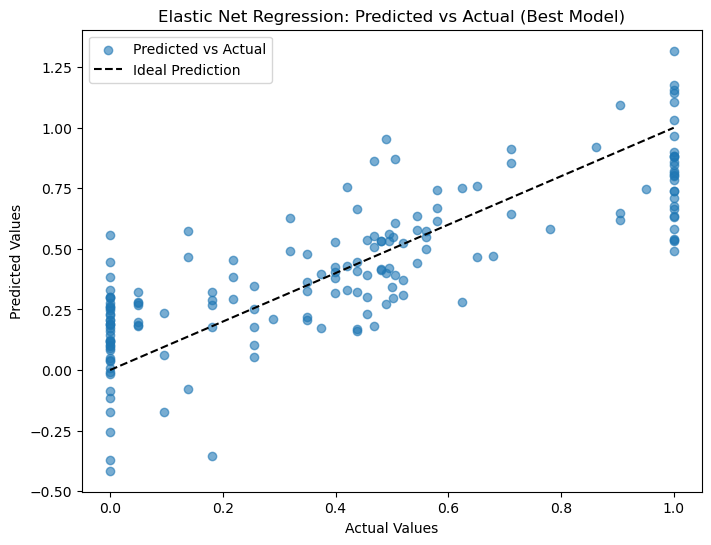

Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.5}
Mean Squared Error: 0.046
R^2 Score: 0.638


({'Mean Squared Error': 0.04578619702698097, 'R^2 Score': 0.6383710597698447},
 {'alpha': 0.01, 'l1_ratio': 0.5})

In [8]:
from sklearn.model_selection import ParameterGrid
def preprocess_data(X, y, task='regression'):
    """
    Preprocesses data by splitting into train-test sets and scaling features.
    For regression, no label encoding is applied.
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test
# Elastic Net Training & Evaluation with Grid Search
def train_evaluate_elastic_net_with_grid_search(X_train, X_test, y_train, y_test, alphas, l1_ratios):
    """
    Trains and evaluates Elastic Net models for a grid of hyperparameters.
    Returns the best model and its metrics.
    """
    best_model = None
    best_metrics = {'Mean Squared Error': float('inf'), 'R^2 Score': -float('inf')}
    best_params = {}

    # Grid search
    param_grid = ParameterGrid({'alpha': alphas, 'l1_ratio': l1_ratios})
    for params in param_grid:
        model = ElasticNet(alpha=params['alpha'], l1_ratio=params['l1_ratio'], max_iter=1000, random_state=42)
        
        # Train model
        model.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = model.predict(X_test)
        
        # Evaluate model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Update best model if current is better
        if mse < best_metrics['Mean Squared Error']:
            best_model = model
            best_metrics = {'Mean Squared Error': mse, 'R^2 Score': r2}
            best_params = params

    # Scatter plot of predictions vs actual values for the best model
    y_pred_best = best_model.predict(X_test)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_best, alpha=0.6, label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Ideal Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Elastic Net Regression: Predicted vs Actual (Best Model)')
    plt.legend(loc="upper left")
    plt.show()
    
    print(f"Best Parameters: {best_params}")
    print(f"Mean Squared Error: {best_metrics['Mean Squared Error']:.3f}")
    print(f"R^2 Score: {best_metrics['R^2 Score']:.3f}")
    
    return best_model, best_metrics, best_params

# Main Execution with Hyperparameter Grid Search
def main():
    """
    Main function for preprocessing data, training Elastic Net with grid search, and displaying results.
    """
    print("\nTraining Elastic Net with Grid Search to predict HRD probabilities:")
    
    # Example data preprocessing
    X_train, X_test, y_train, y_test = preprocess_data(deseq_filtered_rna_seq_df_common, brca_df_common['soft prob'], task='regression')
    
    # Define hyperparameter ranges
    alphas = [0.01, 0.1, 0.25, 0.5, 1.0]
    l1_ratios = [0.1, 0.5, 0.7, 0.9]
    
    best_model, best_metrics, best_params = train_evaluate_elastic_net_with_grid_search(
        X_train, X_test, y_train, y_test, alphas, l1_ratios
    )
    
    return best_model, best_metrics, best_params

# Execute Main
elastic_net_model, elastic_net_metrics, elastic_net_params = main()
elastic_net_metrics, elastic_net_params


In [ ]:
breast_filt = breast_filt.clip(lower=1e-6)

# Apply log2 transformation
breast_filt = np.log2(breast_filt)
breast_filt.index = breast_filt.index.str.split('_').str[0]
# Align breast_filt with deseq_filtered_rna_seq_df_common columns
breast_filt_aligned = breast_filt.reindex(columns=deseq_filtered_rna_seq_df_common.columns, fill_value=0)

# Check for column alignment
print("Are columns aligned?", list(breast_filt_aligned.columns) == list(deseq_filtered_rna_seq_df_common.columns))

feature_columns = breast_filt_aligned.columns  # Adjust if necessary
X = breast_filt_aligned[feature_columns]

# Generate predictions
predictions = elastic_net_model.predict(X)

# Add the predictions to the DataFrame
breast_filt_aligned['Predictions'] = predictions
predictions

Are columns aligned? True


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np

# Load the data
drug_resp = pd.read_csv('../data/validation/BRCA_IC_Sat Jan 18 23_56_13 2025.csv')

# Define PARP inhibitors
parps = ['Olaparib', 'Talazoparib', 'Niraparib', 'Rucaparib', 'Veliparib']

# Filter and select specific drugs
parpi_resp = drug_resp[drug_resp['Drug Name'].isin(parps)]
parpi_resp_filt = parpi_resp[['Drug Name', 'Cell Line Name', 'IC50']].copy()

# Apply transformations explicitly
parpi_resp_filt['IC50'] = parpi_resp_filt['IC50'].clip(lower=1e-6)
parpi_resp_filt['log10IC50'] = np.log10(parpi_resp_filt['IC50'])

parpi_resp_filt["Cell Line Name"] = parpi_resp_filt["Cell Line Name"].str.replace("-", "", regex=True)

merged_df = breast_filt_aligned.merge(
    parpi_resp_filt,
    right_on ='Cell Line Name',
    left_index=True
)
subset_df = merged_df[['Cell Line Name', 'Drug Name', 'Predictions', 'log10IC50']]
subset_df

,Drug Name,Cell Line Name,IC50,log10IC50
0,Olaparib,HCC1954,4.017502,0.603956
1,Olaparib,HCC1143,5.307956,0.724927
2,Olaparib,HCC1187,4.459187,0.649256
3,Olaparib,HCC1395,3.496354,0.543615
4,Olaparib,HCC1599,4.608563,0.663565
...,...,...,...,...
384,Talazoparib,HDQ-P1,3.718242,0.570338
385,Talazoparib,JIMT-1,4.466165,0.649935
386,Talazoparib,HCC1500,5.377461,0.730577
387,Talazoparib,YMB-1-E,2.975015,0.473489


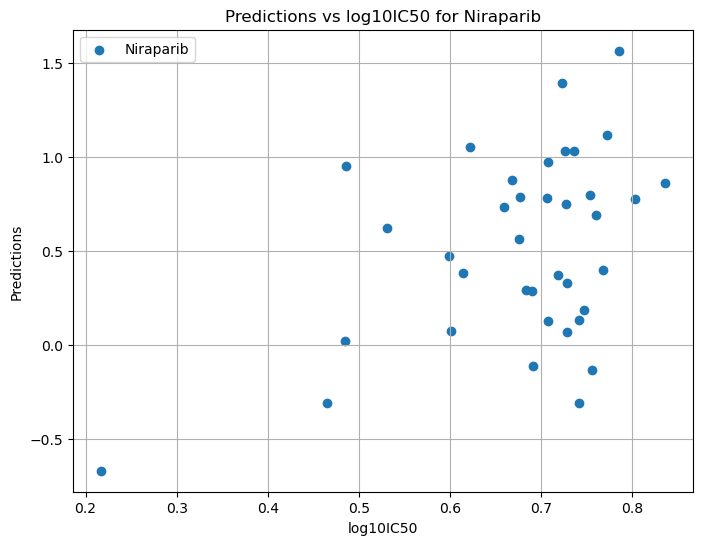

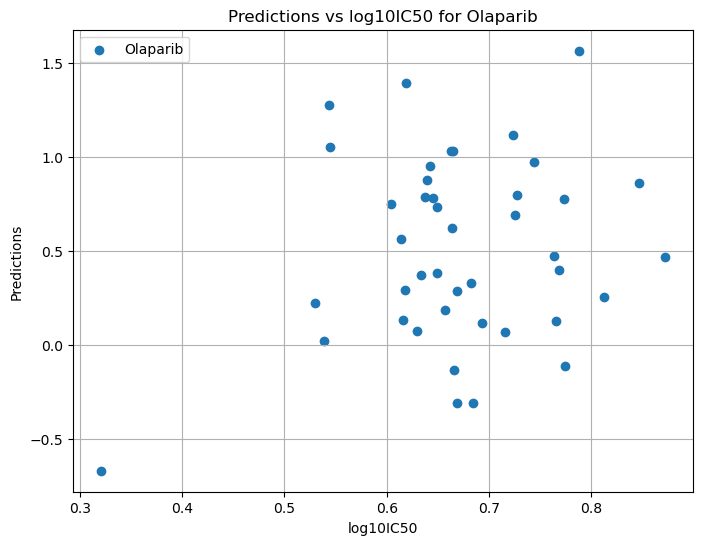

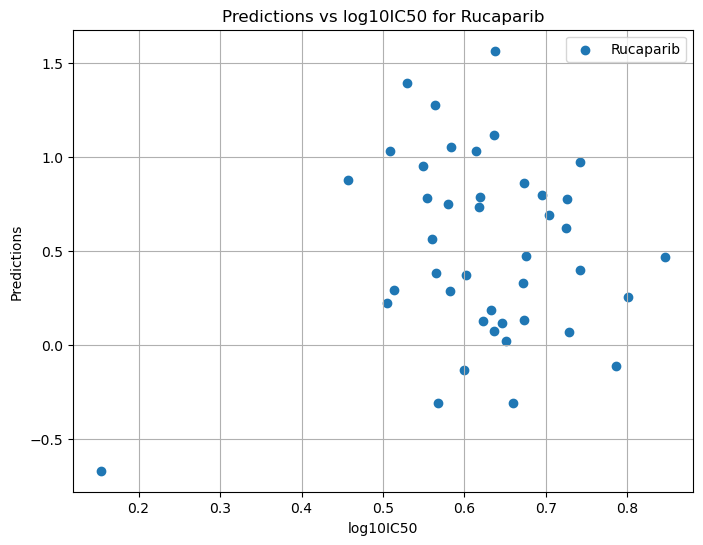

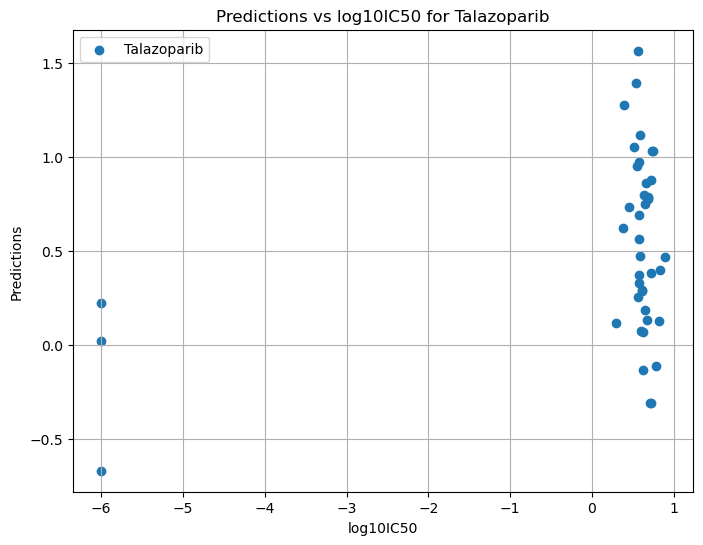

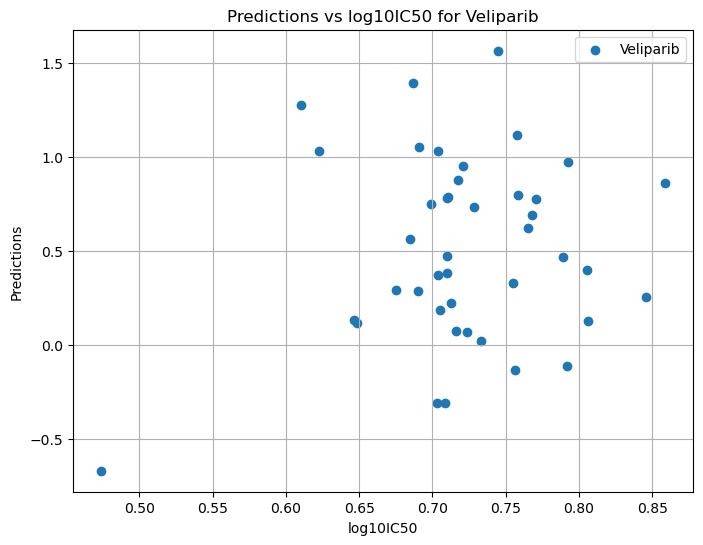

In [14]:
import matplotlib.pyplot as plt

# Group the DataFrame by 'Drug Name'
grouped = merged_df.groupby('Drug Name')

# Loop through each group and create a plot
for drug_name, group in grouped:
    plt.figure(figsize=(8, 6))
    plt.scatter(group['log10IC50'], group['Predictions'], label=drug_name)
    plt.title(f'Predictions vs log10IC50 for {drug_name}')
    plt.xlabel('log10IC50')
    plt.ylabel('Predictions')
    plt.grid(True)
    plt.legend()
    plt.show()
